In [ ]:
# In this notebook we generate new names using a bigram model based on the statistics of names.csv
# We then use Pytorch to do a ultra basic linear descent without any non-linearities to 
# reverse engineer the same bigram matrix, starting from a randomly initialized W (27,27)

In [27]:
import random
words = open('names.csv', 'r').read().splitlines()
words = [s.lower() for s in words]
random.seed(2147483647)
random.shuffle(words)

In [28]:
words[:10]

['calon',
 'enrico',
 'whitlee',
 'dharshik',
 'daniale',
 'shaquaya',
 'konstantin',
 'jerrika',
 'sabrynn',
 'jennings']

In [29]:
# learning some statistical properties about the dataset
len(words), min(len(w) for w in words), max(len(w) for w in words)

(101338, 2, 15)

In [30]:
import torch

In [31]:
# 27x27 maxtrix that contains bigrames for all letters, plus special '.'
N = torch.zeros((27, 27), dtype=torch.int32)

In [32]:
# sanity check that names contains all letters and nothing else
chars = sorted(list(set(''.join(words)))) #set is used to remove dupes
len(chars)

26

In [33]:
# build dict to go from char to int, add '.', and build complementary dict
stoi = {s:i+1 for i,s in enumerate(chars)} 
stoi['.'] = 0 # this will be the special token (start/end)
itos = {i:s for s,i in stoi.items()}

In [34]:
# calculate frequencies of all bigrams accross all words
for w in words:
    # wrap each name on special characters '.'
    chs = ['.'] + list(w) + ['.']
    # generate bigrams, offset word by 1
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        N[ix1, ix2] += 1

(-0.5, 26.5, 26.5, -0.5)

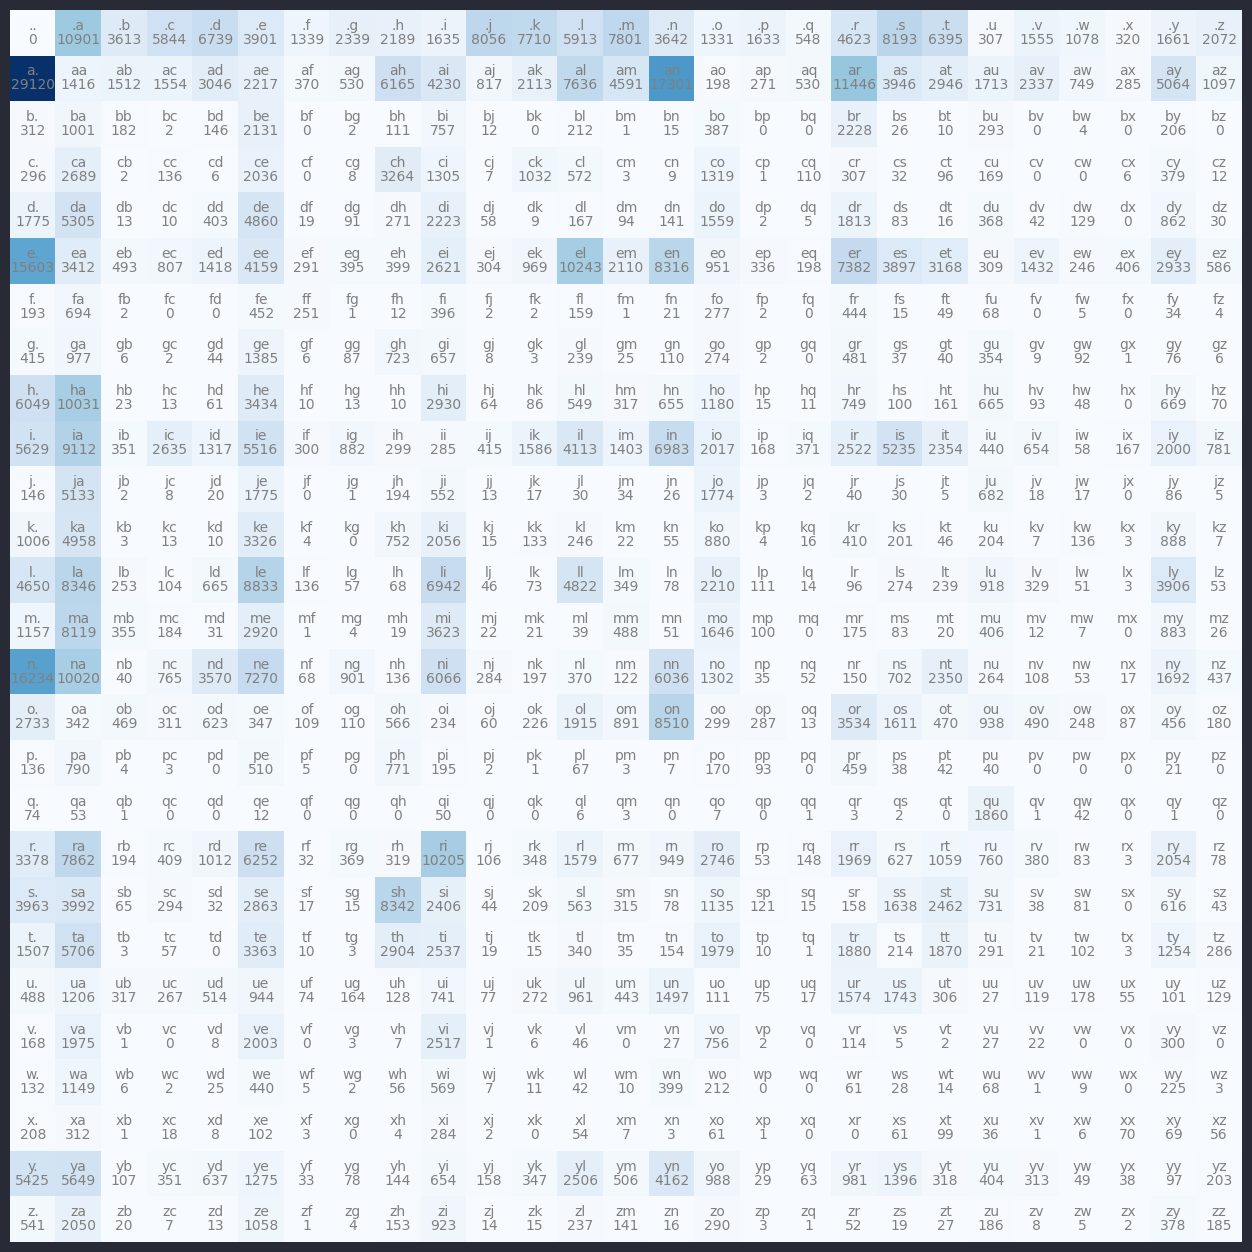

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16, 16))
plt.imshow(N, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j,i, chstr, ha="center", va="bottom", color="gray")
        # note here that N is indexed i,j and not j,i. Not obvious
        plt.text(j,i, N[i,j].item(), ha="center", va="top", color="gray")

plt.axis("off")

In [36]:
# look at first row of N, basically bigrams that start with '.'
# which is the same as saying frequency of starting letters
N[0]

tensor([    0, 10901,  3613,  5844,  6739,  3901,  1339,  2339,  2189,  1635,
         8056,  7710,  5913,  7801,  3642,  1331,  1633,   548,  4623,  8193,
         6395,   307,  1555,  1078,   320,  1661,  2072], dtype=torch.int32)

In [37]:
# convert frequencies to probabilities to normalize
p = N[0].float()
p = p / p.sum()
p, p.sum().item() # each row is normalized, adding up to 1

(tensor([0.0000, 0.1076, 0.0357, 0.0577, 0.0665, 0.0385, 0.0132, 0.0231, 0.0216,
         0.0161, 0.0795, 0.0761, 0.0583, 0.0770, 0.0359, 0.0131, 0.0161, 0.0054,
         0.0456, 0.0808, 0.0631, 0.0030, 0.0153, 0.0106, 0.0032, 0.0164, 0.0204]),
 1.0)

In [38]:
# manual seed for reproducibility
g = torch.Generator().manual_seed(2147483647)

# using torch.multinomial to sample from probabilities p
ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
itos[ix]

'm'

In [39]:
# even with the same manual key, generator will give different results on each subsequent use
# so we re-declare generator to start from scratch
# this is just to show ourselves how it works
# someone following along would get exactly the same 
g = torch.Generator().manual_seed(2147483647)
p = torch.rand(3, generator=g)
p = p / p.sum()
print(f'{p=}')

# sample 100 times from the same distribution with 3 values
torch.multinomial(p, num_samples=100, replacement=True, generator=g)

p=tensor([0.6064, 0.3033, 0.0903])


tensor([1, 1, 2, 0, 0, 2, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 2, 0, 0,
        1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1,
        0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 1, 0,
        0, 1, 1, 1])

In [40]:
# we are now going to calculate P, which is N but normalized as probabilities
# we play a bit with torch to understand dimension manipulation and broadcasting
P = torch.zeros((27,27))
P.shape

torch.Size([27, 27])

In [41]:
# this time we are summing accross each row, dimmension 1 which represents columns
# we keep dimmensions, even though dim 1 will now be [1] containing each row's sum
# this makes broadcasting possible
P.sum(1, keepdim=True).shape, P.sum(1).shape

(torch.Size([27, 1]), torch.Size([27]))

In [42]:
# same as before but across all rows
P = (N+1).float() # +1 to avoid division by zero later
P /= P.sum(1, keepdims=True)

In [43]:
# reset manual seed again
g = torch.Generator().manual_seed(2147483647)

# generate 5 names
for i in range(5):
    out = []
    ix = 0 # start with special character
    while True:
        p = P[ix] #grab current char's row from probability matrix
        # get a prob weighted random character index from row
        # corresponding to the next char (initially 0/.)
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix]) #append char to current name
        if ix == 0: #if we have reached end of sequence, stop
            break
    
    print(''.join(out)) #print last generated name

mor.
avo.
minduproykas.
klemiahlada.
memshizarie.


In [44]:
# GOAL: maximize likelihood of the data w.r.t. model parameters (statistical modeling)
# equivalent to maximizing the log likelihood (because log is monotonic)
# equivalent to minimizing the negative log likelihood
# equivalent to minimizing the average negative log likelihood

# log(a*b*c) = log(a) + log(b) + log(c)

In [45]:
# we are going to calculate the negative log likelihood of our bigram model
# basically we go through all bigrams and we see how well Matrix P predicts next char
log_likelihood = 0.0
n = 0

for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1, ix2 = stoi[ch1], stoi[ch2]
        prob = P[ix1, ix2] #get the probability for this specific bigram
        logprob = torch.log(prob) #calculate the log

        #add to a running total since we want to know loss across set
        log_likelihood += logprob 
        # we divide by n so we can compare across different sample sizes and to keep value stable
        n += 1 

print(f'{log_likelihood=}')
nll = -log_likelihood
print(f'{nll=}')
print(f'{nll/n}')

log_likelihood=tensor(-1877230.5000)
nll=tensor(1877230.5000)
2.460902452468872


In [46]:
# let's loop through the chars of one name, and put them inside tensors
xs, ys = [], []

for w in words[1:2]:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1, ix2 = stoi[ch1], stoi[ch2]
        print(ch1, ch2)
        xs.append(ix1)
        ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

. e
e n
n r
r i
i c
c o
o .


In [78]:
xs, ys

(tensor([ 0, 12,  1, 10,  1, 25, 12,  1]),
 tensor([12,  1, 10,  1, 25, 12,  1,  0]))

In [47]:
#make one hot encodings for chars
import torch.nn.functional as F
xenc = F.one_hot(xs, num_classes=27).float()
xenc

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [49]:
# 7 characters with a 1/27 hot encoding for each char
xenc.shape


torch.Size([7, 27])

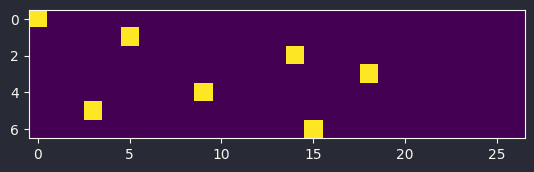

In [50]:
plt.imshow(xenc)

In [52]:
# now we will build a matrix W that looks like N or P
# this contains the random weights we will later optimize 
# but W is neither N (counts) or P(probabilities) we can think of it as the log of the counts
# this is because we are going to use negative log likelihood as the loss function

g = torch.Generator().manual_seed(2147483647)

W = torch.randn((27, 27))
# row in W with the bigram "log counts" corresponding to each one hot char in xenc
logits = xenc @ W 
counts = logits.exp() #equivalent to N before normalizing to P
probs = counts / counts.sum(1, keepdims=True) #equivalent to P
probs

tensor([[0.0194, 0.0094, 0.0193, 0.0176, 0.0116, 0.0079, 0.0219, 0.1144, 0.0287,
         0.0391, 0.0145, 0.0110, 0.0143, 0.0489, 0.0160, 0.0182, 0.0187, 0.0432,
         0.0432, 0.0135, 0.2148, 0.0586, 0.0165, 0.0073, 0.1621, 0.0036, 0.0063],
        [0.0084, 0.0949, 0.0161, 0.0599, 0.0404, 0.0490, 0.0429, 0.0522, 0.0116,
         0.0096, 0.0814, 0.0433, 0.0730, 0.0201, 0.0245, 0.0694, 0.0049, 0.0401,
         0.0082, 0.0045, 0.0083, 0.0161, 0.0122, 0.0294, 0.1511, 0.0084, 0.0201],
        [0.0181, 0.0143, 0.0207, 0.0414, 0.0439, 0.0713, 0.0203, 0.0248, 0.0188,
         0.0142, 0.0163, 0.0189, 0.0264, 0.0288, 0.0097, 0.0165, 0.0070, 0.0909,
         0.0105, 0.0143, 0.0077, 0.0431, 0.0628, 0.0172, 0.1407, 0.0389, 0.1622],
        [0.1267, 0.0188, 0.0722, 0.0692, 0.0110, 0.0111, 0.0716, 0.0141, 0.1340,
         0.0307, 0.0308, 0.0045, 0.0182, 0.0081, 0.0772, 0.0203, 0.0218, 0.0567,
         0.0230, 0.0402, 0.0265, 0.0123, 0.0328, 0.0072, 0.0057, 0.0473, 0.0079],
        [0.0965, 0.1112,

In [54]:
# just like before, we can take one row
# we see it has 27 probabilities, one for every possible bigram
# and we also see that they add up to 1
probs[0], probs[0].shape, probs[0].sum()

(tensor([0.0194, 0.0094, 0.0193, 0.0176, 0.0116, 0.0079, 0.0219, 0.1144, 0.0287,
         0.0391, 0.0145, 0.0110, 0.0143, 0.0489, 0.0160, 0.0182, 0.0187, 0.0432,
         0.0432, 0.0135, 0.2148, 0.0586, 0.0165, 0.0073, 0.1621, 0.0036, 0.0063]),
 torch.Size([27]),
 tensor(1.))

In [55]:
# now we are going to try to train the parameters of W to mirror log-counts, basically log(N)

xs, ys = [], [] #inputs, labels

for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1, ix2 = stoi[ch1], stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement() #keep track of count to normalize
print('number of examples:', num)

# randomly initialize 27 neurons' weights. each neuron receives 27 inputs
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27,27), generator=g, requires_grad=True) #we require gradient so we can call .backward()


#gradient descent
for k in range(200):

    # forward pass
    xenc = F.one_hot(xs, num_classes=27).float() #we are operating on the entire dataset xs
    logits = xenc @ W # "predicts" log-counts
    counts = logits.exp() #equivalent to N
    probs = counts / counts.sum(1, keepdims=True) #equivalent to P for next character
    # the last two lines together are a softmax

    # the loss is the negative log likelihood of each row of the probability matrix
    # selecting the column corresponding to the expected next character ys
    # we add weight normalization to loss to prevent parameters from exploding in magnitude
    loss = -probs[torch.arange(num), ys].log().mean() + 0.01*(W**2).mean()

    if k%25 == 0:
        print(loss.item())

    # backward pass
    W.grad = None
    loss.backward()

    #update
    W.data += -50 * W.grad



number of examples: 762822
3.7977349758148193
2.55922794342041
2.5121424198150635
2.499053955078125
2.493453025817871
2.4905219078063965
2.488800525665283
2.4877114295959473


In [57]:
# recall the static solution gave us a average nll of 2.4609, so pretty close

# now generate some names from this model
g = torch.Generator().manual_seed(2147483647)

for i in range(10):
    out=[]
    ix=0
    while True:
        xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
        logits = xenc @ W #predict log counts
        counts = logits.exp() #equivalent to N
        p = counts / counts.sum(1, keepdims=True) #probability for next char

        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])

        if ix == 0:
            break
    print(''.join(out))

mor.
avo.
minduqusykas.
kmamiahlada.
memumizarie.
ra.
ren.
jaaecon.
jajionconanadayrhj.
h.


In [59]:
# here's a breakdown of the various parameters and calculations inside this model

nlls = torch.zeros(5)
for i in range(5):
  # i-th bigram:
  x = xs[i].item() # input character index
  y = ys[i].item() # label character index
  print('--------')
  print(f'bigram example {i+1}: {itos[x]}{itos[y]} (indexes {x},{y})')
  print('input to the neural net:', x)
  print('output probabilities from the neural net:', probs[i])
  print('label (actual next character):', y)
  p = probs[i, y]
  print('probability assigned by the net to the the correct character:', p.item())
  logp = torch.log(p)
  print('log likelihood:', logp.item())
  nll = -logp
  print('negative log likelihood:', nll.item())
  nlls[i] = nll

print('=========')
print('average negative log likelihood, i.e. loss =', nlls.mean().item())



--------
bigram example 1: .c (indexes 0,3)
input to the neural net: 0
output probabilities from the neural net: tensor([0.0010, 0.1072, 0.0356, 0.0575, 0.0663, 0.0384, 0.0133, 0.0231, 0.0216,
        0.0162, 0.0792, 0.0758, 0.0581, 0.0767, 0.0358, 0.0132, 0.0162, 0.0057,
        0.0455, 0.0806, 0.0629, 0.0034, 0.0154, 0.0108, 0.0035, 0.0164, 0.0205],
       grad_fn=<SelectBackward0>)
label (actual next character): 3
probability assigned by the net to the the correct character: 0.05746899172663689
log likelihood: -2.8565096855163574
negative log likelihood: 2.8565096855163574
--------
bigram example 2: ca (indexes 3,1)
input to the neural net: 3
output probabilities from the neural net: tensor([0.0195, 0.1896, 0.0030, 0.0101, 0.0044, 0.1427, 0.0035, 0.0033, 0.2310,
        0.0904, 0.0043, 0.0709, 0.0382, 0.0037, 0.0048, 0.0914, 0.0039, 0.0069,
        0.0200, 0.0043, 0.0070, 0.0087, 0.0039, 0.0026, 0.0040, 0.0240, 0.0038],
       grad_fn=<SelectBackward0>)
label (actual next character)